**Things to Implement:**
1. ~~weight initialization methods~~
2. Validation set for hyperparameter tuning
    + Hyperparameters:
        + depth
        + width
        + learning rate $\eta$
        + batch size $B$
        + convergence criteria
3. ~~Making sure input data is zero-centered with normalized variance~~
     + ~~Maybe normalize the response variable as well~~
4. Momentum in stochastic gradient descent
5. Annealing (decaying) learning rate
    + ~~multiply by a constant on every iteration~~
    + or reduce it when the validation loss isn't decreasing any more.
6. Stopping Criterion
    + based on average batch loss?
7. Weight regularization
    + to control overfitting

### Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Defining Layers

**Types of Layers:**
1. Loss layer (final layer, outputs a single value)
2. Output layer (outputs a Bx1 vector)
3. Activation layer (activation function sigma applied to hidden layer)
4. Hidden layer

In [3]:
# then if it's first iteration just set it to the weight gradient
class LossLayer:
    def __init__(self, avg_loss=None, y_vec=None):
        self.avg_loss = None
        self.y_vec = y_vec
        
    def __repr__(self):
        return '{layer type: Loss, average loss: ' +  (str(self.avg_loss) if self.avg_loss is not None else "None") +  ', true y values shape: ' + (str(self.y_vec.shape) if self.y_vec is not None else "None") + '}'
    
    def __str__(self):
        return repr(self)
    
    
class OutputLayer:
    def __init__(self, array=None, weights=None, velocity=None):
        self.array = array
        self.weights = weights
        self.velocity = velocity
        
    def __repr__(self):
        return '{layer type: Output, output array shape: ' +  (str(self.array.shape) if self.array is not None else "None") + ', weights shape: ' + (str(self.weights.shape) if self.weights is not None else "None") + '}'
    
    def __str__(self):
        return repr(self)
    

class ActivationLayer:
    def __init__(self, array=None):
        self.array = array
        
    def __repr__(self):
        return '{layer type: Activation, output array shape: ' + (str(self.array.shape) if self.array is not None else "None") + '}'
    def __str__(self):
        return repr(self)
    
    
class HiddenLayer:
    def __init__(self, array=None, weights=None, velocity=None):
        self.array = array
        self.weights = weights
        self.velocity=None
        
    def __repr__(self):
        return '{layer type: Hidden, output array shape: ' + (str(self.array.shape) if self.array is not None else "None") + ', weights shape: ' + (str(self.weights.shape) if self.weights is not None else "None") + '}'

### Implementing Network

In [167]:
class NeuralNetwork:
    def __init__(self, depth, width, batch_size = 128, learning_rate_init = 0.0001, convergence_criteria = 0.001, max_num_iterations = 1000, momentum=1, activation = "relu", lambda_rate = 1, weight_initialization = 'He'):
        self.depth = depth
        self.width = width
        self.B = batch_size
        self.learning_rate_init = learning_rate_init
        self.conv_crit = convergence_criteria
        self.max_num_iterations = max_num_iterations
        self.momentum = momentum
        self.activation_function = {'relu': self.__ReLU, 'leaky relu': self.__leaky_ReLU, 'tanh': self.__tanh, 'sigmoid': self.__sigmoid}[activation] # did I just crack the case of the case/switch in python????
        self.deriv_activation_function = {'relu': self.__ReLU_derivative, 'leaky relu': self.__leaky_ReLU_derivative, 'tanh': self.__tanh_derivative, 'sigmoid': self.__sigmoid_derivative}[activation]
        self.lambda_rate = lambda_rate
        self.weight_initialization = weight_initialization
        self.layers = []
        self.num_parameters = 0
        self.losses = []
        self.rmses = []
        self.train_stats = [["=" * 38 + '{}', ""],
                            ["Number of trainable parameters: {}", None],
                            ["Number of epochs until convergence: {}", None],
                            ["Training average batch loss: {}", None],
                            ["Training RMSE: {}", None],
                            ["Standard deviation of y_train: {}", None],
                            ["=" * 38 + '{}', ""]]

        # Initializing the layers in the network
        
        # I don't know the weight dimensions yet so I can't define the first hidden layer's weights. 
        self.layers.append(HiddenLayer())
        self.layers.append(ActivationLayer())
        
        for i in range(1, self.depth): # skip the first hidden layer because its weights' shape depends on number of input columns
            
            # create hidden layer with weight dimensions (width + 1) x width using He weight initialization method
            self.layers.append(HiddenLayer(weights = self.__initialize_weights(shape=(self.width + 1, self.width), method=self.weight_initialization)))
            
            # create activatin layer
            self.layers.append(ActivationLayer())
            
            # update number of parameters
            self.num_parameters += (self.width + 1) * self.width
            
            
            
        # make an output layer that creates a scalar with its weights
        z_layer = OutputLayer(weights=self.__initialize_weights(shape=(self.width + 1, 1), method=self.weight_initialization))
        self.num_parameters += (self.width + 1) * 1
        self.layers.append(z_layer)

        # make a loss layer
        loss_layer = LossLayer()
        self.layers.append(loss_layer)
        
    #----------Basic Object Functions----------#
    
    def __repr__(self):
        return '[' + '\n'.join([str(layer) for layer in self.layers]) + ']'

    
    def __str__(self):
        return repr(self)
        
    #----------Activation Functions and Their Derivatives----------#
    
    def __ReLU(self, vec):
        return np.where(vec <= 0, 0, vec)


    def __ReLU_derivative(self, vec):
        return np.where(vec <= 0, 0, 1)


    def __leaky_ReLU(self, vec):
        return np.where(vec <= 0, 0.1 * vec, vec)


    def __leaky_ReLU_derivative(self, vec):
        return np.where(vec <= 0, 0.1, 1)
    
    
    def __tanh(self, vec):
        return (2 * self.__sigmoid(vec)) - 1

    
    def __tanh_derivative(self, vec):
        return 1 - np.power(self.__tanh(vec), 2)


    def __sigmoid(self, vec):
        return np.where(vec < 0, 1 - (1 / (1 + np.exp(vec))), 1 / (1 + np.exp(-1 * vec)))

    
    def __sigmoid_derivative(self, vec):
        return self.__sigmoid(vec) * (1 - self.__sigmoid(vec))
    
    
    #----------Model Evaluation Functions----------#
    
    def __loss(self, num, y):
        return (1/2) * np.power(num - y, 2)

    
    def __average_batch_loss(self, vec, y):
        B = vec.shape[0]
        losses = self.__loss(vec.reshape(B,), y)
        return (1 / B) * losses.sum()
            
        
    def __rmse(self, y, y_hat):
        return np.sqrt(np.power(y - y_hat, 2).sum() / y.shape[0])
        

    def __forward_pass(self, X_batch, y_vec):

        # Append column of 1s to end of this batch, to hide bias term
        X_w_bias = np.concatenate([X_batch, np.ones(shape=(self.B, 1))], axis=1)
        
        i = 0

        # first apply weights to input layer and save result in first hidden layer
        self.layers[i].array = X_w_bias.dot(self.layers[i].weights)

        i += 1

        while i < len(self.layers):
            if isinstance(self.layers[i], LossLayer):  # if this is a LossLayer:
                # then apply loss function to B x 1 vector to get 1 x 1 average loss over this batch
                avg_loss = self.__average_batch_loss(self.layers[i - 1].array, y_vec)
                rmse = self.__rmse(self.layers[i - 1].array, y_vec)
                self.layers[i].avg_loss = avg_loss
                self.losses.append(avg_loss)
                self.rmses.append(rmse)
                self.layers[i].y_vec = y_vec
            elif isinstance(self.layers[i], ActivationLayer):  # if this is an activation layer
                # then apply activation function to previous layer and save result
                self.layers[i].array = self.activation_function(self.layers[i - 1].array)
            else:  # if this is a Hidden Layer of an Output Layer:
                # add bias column, then apply this layer's weights to the previous layer and save result in current layer
                input_w_bias = np.concatenate([self.layers[i - 1].array, np.ones(shape=(self.B, 1))], axis=1)
                self.layers[i].array = input_w_bias.dot(self.layers[i].weights)


            i += 1

    #----------Stochastic Gradient Descent Functions----------#
    
    def __initialize_weights(self, shape, method = "Common"):
        # replace self.B with n_i where n_i is # of elements in array being passed
        if method == "Common":
            wt = np.random.uniform((-1 / np.sqrt(shape[0] - 1)), (1 / np.sqrt(shape[0] - 1)), size=(shape[0] - 1, shape[1]))
        else:
            wt = np.random.normal(loc=0, scale=np.sqrt(2 / shape[0]), size=(shape[0] - 1, shape[1]))
            
        zeros = np.zeros((1, shape[1]))
        return np.concatenate([wt, zeros], axis=0)
        
        
    def __get_batch(self, X, y):
        indices = np.random.randint(X.shape[0], size=self.B)
        return X[indices, :], y[indices]
    
            
    def __backward_pass(self, X_batch, learning_rate):
        X_w_bias = np.concatenate([X_batch, np.ones(shape=(self.B, 1))], axis=1)

        i = len(self.layers) - 1  # start at the loss layer

        while i > 0:  # while we still have layers to traverse through backwards that aren't the first hidden layer
            if isinstance(self.layers[i], LossLayer):  # if this is a loss layer:
                input_x_vec = self.layers[i - 1].array  # get the x values that were inputted to this loss function
                J = input_x_vec - self.layers[i].y_vec.reshape(self.B, 1)  # the derivative of our loss function is just x - y
            elif isinstance(self.layers[i], ActivationLayer):  # if this is an activation layer:
                J_update = self.deriv_activation_function(self.layers[i - 1].array)  # calcluate derivative (of ReLU) of every value that was inputted to this layer
                J = J * J_update  # update J with these values
            else:  # if this is a hidden layer or output layer (anything that has weights)
                # append bias vector to the array that was inputted to this layer:
                input_w_bias = np.concatenate([self.layers[i - 1].array, np.ones(shape=(self.B, 1))], axis=1)

                weight_update = np.transpose(input_w_bias).dot(J)  # calculate the weight update by doing xT * J
                J = J.dot(np.transpose(self.layers[i].weights[:-1, :]))  # Update the Jacobian by doing J * wT

                self.layers[i].weights = self.layers[i].weights - (learning_rate * weight_update)  # apply the weight update, multiplying by learning rate first
            i -= 1

        # now we update the weights of the very first hidden layer (it has special weight dimensions)
        # so i = 0

        weight_update = np.transpose(X_w_bias).dot(J)

        self.layers[i].weights = self.layers[i].weights - (learning_rate * weight_update)  # apply the weight update, multiplying by learning rate first
        
        
    def __backward_pass_momentum(self, X_batch, learning_rate):
        
        # velocity needs to get initialized somewhere here???
        
        X_w_bias = np.concatenate([X_batch, np.ones(shape=(self.B, 1))], axis=1)
        
        i = len(self.layers) - 1  # start at the loss layer
        
        while i > 0:  # while we still have layers to traverse through backwards that aren't the first hidden layer
            if isinstance(self.layers[i], LossLayer):  # if this is a loss layer:
                input_x_vec = self.layers[i - 1].array  # get the x values that were inputted to this loss function
                J = input_x_vec - self.layers[i].y_vec.reshape(self.B, 1)  # the derivative of our loss function is just x - y
            elif isinstance(self.layers[i], ActivationLayer):  # if this is an activation layer:
                J_update = self.deriv_activation_function(self.layers[i - 1].array)  # calcluate derivative (of ReLU) of every value that was inputted to this layer
                J = J * J_update  # update J with these values
            else:  # if this is a hidden layer or output layer (anything that has weights)
                # append bias vector to the array that was inputted to this layer
                input_w_bias = np.concatenate([self.layers[i - 1].array, np.ones(shape=(self.B, 1))], axis=1)
                
                if self.layers[i].velocity is None: # if this is the very first backward pass so this layer doesn't have a velocity matrix
                    # then initialize it to the gradient times learning rate
                    self.layers[i].velocity = - (learning_rate * np.transpose(input_w_bias).dot(J))
                else: # if this isn't the first backward pass so this layer has a velocity
                    # calculate velocity update by doing multiplying previous velocity by momentun, then subtracting off the learning rate * weight update
                    self.layers[i].velocity = (self.momentum * self.layers[i].velocity) - (learning_rate * np.transpose(input_w_bias).dot(J))
                
                J = J.dot(np.transpose(self.layers[i].weights[:-1, :]))  # Update the Jacobian by doing J * wT

                self.layers[i].weights += self.layers[i].velocity  # apply the weight update, multiplying by learning rate first
            i -= 1

        # now we update the weights of the very first hidden layer (it has special weight dimensions)
        # so i = 0

        weight_update = np.transpose(X_w_bias).dot(J)

        self.layers[i].weights = self.layers[i].weights - (learning_rate * weight_update)  # apply the weight update, multiplying by learning rate first
    
        
    def fit(self, X, y):
        
        # initialize the first hidden layer's weights now that I know what the input dimensions are
        self.layers[0].weights=self.__initialize_weights(shape=(X.shape[1] + 1, self.width), method=self.weight_initialization)
        self.num_parameters += (X.shape[1] + 1) * self.width
        
        current_lr = self.learning_rate_init
        
        current_loss = float('inf') # initialize loss to infinity
        
        i = 0
        converged = False
        
        while not converged:
            this_X, this_y = self.__get_batch(X, y)
            self.__forward_pass(this_X, this_y)
            self.__backward_pass_momentum(this_X, current_lr)
            
            if (i % 50 == 0) and (i > 0): # if the iteration number is a multiple of 50:
                #print('i = {}, using lr = {}'.format(i, current_lr))
                loss_diff = current_loss - self.losses[-1] # calculate change in loss (old - new)
                #print('loss_diff = {}'.format(loss_diff))
                converged = (loss_diff > 0) and (loss_diff < self.conv_crit) # check if our loss improved and improvement is less than criteria
                #print('converged = {}'.format(converged))
                current_loss = self.losses[-1] # update current loss
                #print('-' * 40)
                
                
            if (self.lambda_rate != 1) and (i % 30 == 0) and (i > 0) and (self.losses[i] >= self.losses[i - 10]): # every 10 iterations, if the loss hasn't decreased in the past 10 iterations
                current_lr = self.lambda_rate * current_lr # then decrease the learning rate
                
            i += 1
            
            if i > self.max_num_iterations: # if we have surpassed the maximum number of iterations
                converged = True # then stop
            
        full_preds = self.predict(X)
        
        final_loss = self.__average_batch_loss(full_preds, y)
        final_rmse = self.__rmse(y, full_preds)
        
        # save the stats in case they are asked to be printed out later.
        self.train_stats[1][1] = self.num_parameters
        self.train_stats[2][1] = len(self.losses)
        self.train_stats[3][1] = round(final_loss, 5)
        self.train_stats[4][1] = round(final_rmse, 5)
        self.train_stats[5][1] = round(y.std(), 5)
        
        
    def train_loss(self):
        return self.train_stats[2][1]
    
    def train_rmse(self):
        return self.train_stats[3][1]
    
    def train_metrics(self, rmse_curve=False):
        print("\n".join([item[0].format(item[1]) for item in self.train_stats]))
        
        plt.plot(range(len(self.losses)), self.losses)
        plt.title("Batch Loss for batch size {}, learning rate {}".format(self.B, self.learning_rate_init))
        plt.xlabel("Epoch")
        plt.ylabel("Average Batch Loss")
        plt.show()
        
        if rmse_curve:
            plt.plot(range(len(self.rmses)), self.rmses)
            plt.title("Batch RMSE for batch size {}, learning rate {}".format(self.B, self.learning_rate_init))
            plt.xlabel("Epoch")
            plt.ylabel("Batch RMSE")
            plt.show()
        
        
    def predict(self, X):
        # Append column of 1s to end of this data, to hide bias term
        this_B = X.shape[0]
        current_array = np.concatenate([X, np.ones(shape=(this_B, 1))], axis=1)
        i = 0

        # first apply weights to input layer and save result in first hidden layer
        current_array = current_array.dot(self.layers[i].weights)

        i += 1

        while i < (len(self.layers) - 1): # minus one to avoid hitting the loss layer
            if isinstance(self.layers[i], ActivationLayer):  # if this is an activation layer
                # then apply activation function to previous result
                current_array = self.activation_function(current_array)
            else:  # if this is a Hidden Layer of an Output Layer:
                # add bias column, then apply this layer's weights to the previous layer and save result in current layer
                current_array = np.concatenate([current_array, np.ones(shape=(this_B, 1))], axis=1)
                current_array = current_array.dot(self.layers[i].weights)


            i += 1
            
        return current_array.reshape(this_B, )
    
    
    
    def validate(self, X_val, y_val):
        preds = self.predict(X_val)
        
        print("=" * 38)
        print("Validation average batch loss: {:.5f}".format(self.__average_batch_loss(preds, y_val)))
        print("Validation RMSE: {:.5f}".format(self.__rmse(y_val, preds)))
        print("Standard deviation of y_val: {:.5f}".format(y_val.std()))
        print("=" * 38)

Number of trainable parameters: 81
Number of epochs until convergence: 351
Training average batch loss: 0.0496
Training RMSE: 0.31497
Standard deviation of y_train: 1.80837


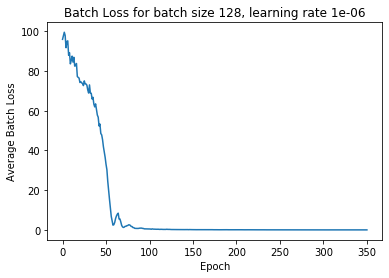

In [168]:
net = NeuralNetwork(depth=3, width=5,
                    batch_size = 128,
                    learning_rate_init = 0.000001,
                    convergence_criteria = 0.005,
                    max_num_iterations = 1000,
                    momentum=0.9,
                    activation = "leaky relu",
                    lambda_rate = 1,
                    weight_initialization = 'He')

net.fit(X, y)
net.train_metrics()

### Trying the Training Process

#### Creating 2000 rows of data

In [19]:
# number of rows to create
nrows = 2000

# define x features
x1 = np.random.normal(loc=5, scale=2, size=nrows) # generate 40 values from Normal(5, 2)
x2 = np.random.normal(loc=10, scale=2, size=nrows) # generate 40 values from Normal(10, 2)

# define coeffients to use for linear combination
beta_0 = 3
beta_1 = 0.5
beta_2 = 0.75

# Define X and y
X = np.concatenate([x1.reshape(nrows, 1), x2.reshape(nrows, 1)], axis=1)
y = beta_0 + (beta_1 * X[:, 0]) + (beta_2 * X[:, 1])  # make a linear combination of x1 and x2 to be y

#### Training with data I created

**Small network for small data**

Number of trainable parameters: 37
Training average batch loss: 0.17662
Training RMSE: 0.59433
Standard deviation of y_train: 1.80837


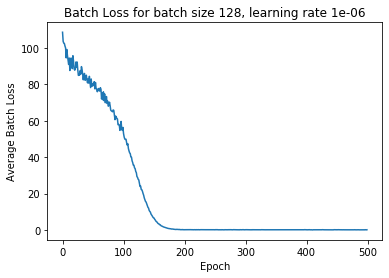

In [24]:
# Hyperparameters:
batch_size = 128
learning_rate = 0.000001
max_num_iterations = 500
depth = 2
width = 4


# Training:
train_net = NeuralNetwork(depth, width,
                          batch_size,
                          learning_rate, max_num_iterations,
                          activation = "leaky relu")
train_net.fit(X, y)
train_net.train_metrics()

**Network that is too complex for small, simple data**

Number of trainable parameters: 2751
Training average batch loss: 0.26664
Training RMSE: 0.73026
Standard deviation of y_train: 1.80837


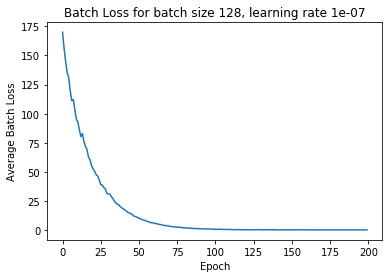

In [27]:
# Hyperparameters:
batch_size = 128
learning_rate = 0.0000001
max_num_iterations = 200
width = 50
depth = 2

# Training:
train_net  =NeuralNetwork(depth, width,
                          batch_size,
                          learning_rate, max_num_iterations,
                          activation = "leaky relu")
train_net.fit(X, y)
train_net.train_metrics()

#### Training with Josiah's Data

**Reading in and cleaning data, getting Training and Validation Sets**

In [155]:
# Read in data
jdata = pd.read_csv('josiah_final_data.csv')

# remove timestamp
jdata_feat = jdata.drop(columns=['timestamp'])
X_train, X_val = train_test_split(jdata_feat, test_size=0.1)

**Standardizing Predictors and Response**

In [156]:
standardizer = StandardScaler().fit(X_train)
X_train_std = standardizer.transform(X_train)
X_val_std = standardizer.transform(X_val)

**Extracting Response**

In [157]:
# remove response and save
y_train_std = X_train_std[:, -1]
X_train_std = X_train_std[:, :-1]

# remove response and save
y_val_std = X_val_std[:, -1]
X_val_std = X_val_std[:, :-1]

print("Standard Deviation of y_train_std: {:.5f}".format(y_train_std.std()))
print("Standard Deviation of y_val_std: {:.5f}".format(y_val_std.std()))

Standard Deviation of y_train_std: 1.00000
Standard Deviation of y_val_std: 0.99669


Number of trainable parameters: 21231
Number of epochs until convergence: 751
Training average batch loss: 0.02519
Training RMSE: 0.22448
Standard deviation of y_train: 1.0


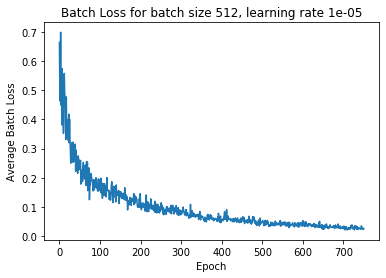

Validation average batch loss: 0.02683
Validation RMSE: 0.23163
Standard deviation of y_val: 0.99669


In [173]:
# Hyperparameters:
batch_size = 512
learning_rate = 0.00001
max_num_iterations = 750
depth = 7
width = 55
#conv_crit = 0.0008
conv_crit = 0.001


# Training:
train_net = NeuralNetwork(depth, width,
                          batch_size,
                          learning_rate_init = learning_rate,
                          max_num_iterations = max_num_iterations,
                          convergence_criteria = conv_crit,
                          momentum=0.95,
                          activation = "leaky relu",
                          lambda_rate = 1,
                          weight_initialization = 'He')


train_net.fit(X_train_std, y_train_std)
train_net.train_metrics()
train_net.validate(X_val_std, y_val_std)

**Hyperparameters:**
1. Depth
2. Width
3. Batch Size
4. Learning Rate
5. ~~Activation Function (leaky ReLU vs. ReLU)~~
6. Lambda Multiplier for Annealing Learning Rate
    + I found this doesn't help much or it isn't working correctly, seems to make endgame more unstable
7. Convergence criteria

**Order to implement:**
1. ~~Convergence Criteria~~
2. ~~Momentum~~
3. ~~Other annealing strategy?~~
4. Grid Search
5. Weight Regularization